### 1. Problem Statment

Preform the emotional classification based on the given reviews.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
import nltk
import re
import emoji
import pickle
import collections
from collections import Counter
import wordcloud
from wordcloud import WordCloud
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize,sent_tokenize
from nltk.stem import PorterStemmer,LancasterStemmer,SnowballStemmer,WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import BernoulliNB,MultinomialNB
from sklearn.metrics import accuracy_score,confusion_matrix,classification_report
from sklearn.pipeline import Pipeline,make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import FunctionTransformer,PowerTransformer,StandardScaler,LabelEncoder

### 2. Data Collection

In [2]:
data = pd.read_csv(r"C:\Users\pavan\Machine Learning\Projects\Project-7(Emotion)\Emotion_classify_Data.csv")

In [3]:
df = data.copy()

In [4]:
df.head()

,Comment,Emotion
0,i seriously hate one subject to death but now ...,fear
1,im so full of life i feel appalled,anger
2,i sit here to write i start to dig out my feel...,fear
3,ive been really angry with r and i feel like a...,joy
4,i feel suspicious if there is no one outside l...,fear


### 3. EDA Before Pre-Processing

In [5]:
df.shape

(5937, 2)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5937 entries, 0 to 5936
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   Comment  5937 non-null   object
 1   Emotion  5937 non-null   object
dtypes: object(2)
memory usage: 92.9+ KB


In [7]:
df.isnull().sum()

Comment    0
Emotion    0
dtype: int64

In [8]:
df.duplicated().sum()

0

In [9]:
df['Emotion'].value_counts()

anger    2000
joy      2000
fear     1937
Name: Emotion, dtype: int64

In [10]:
feature_var = df['Comment']

In [11]:
feature_var.head()

0    i seriously hate one subject to death but now ...
1                   im so full of life i feel appalled
2    i sit here to write i start to dig out my feel...
3    ive been really angry with r and i feel like a...
4    i feel suspicious if there is no one outside l...
Name: Comment, dtype: object

In [12]:
def EDA_1(data):

    case = " ".join(data).islower()
    html = data.apply(lambda x:True if re.search("<.+?>",x) else False).sum()
    url = data.apply(lambda x:True if re.search("http[s]?://.+? +",x) else False).sum()
    unwanted = data.apply(lambda x:True if re.search("[]()*\-.:,@#$%&^!?/0-9']",x) else False).sum()

    count = 0
    for sen in data:
        for char in sen.split():
            if emoji.is_emoji(char):
                count += 1

    if case == False:
        print("Contains non lowercase letters")
    else:
        print('All are in lowercase letters')

    if html > 0:
        print("Contains html tags")
    else:
        print('No html tags')

    if url > 0:
        print("Contains urls")
    else:
        print('No urls')

    if unwanted > 0:
        print("Contains unwanted characters")
    else:
        print('No unwanted characters')

    if count > 0:
        print('Contains Emoji')
    else:
        print('No Emoji')

In [13]:
EDA_1(feature_var)

All are in lowercase letters
No html tags
No urls
No unwanted characters
No Emoji


In [14]:
class_var = df['Emotion']

In [15]:
class_var.head()

0     fear
1    anger
2     fear
3      joy
4     fear
Name: Emotion, dtype: object

In [16]:
class_var_encoding = LabelEncoder()

class_var = class_var_encoding.fit_transform(class_var)

class_var = pd.Series(class_var)

In [17]:
class_var.head()

0    1
1    0
2    1
3    2
4    1
dtype: int32

In [18]:
x_train,x_test,y_train,y_test = train_test_split(feature_var, class_var, test_size= 0.2, random_state= 1, stratify= class_var)

In [19]:
x_train,x_cv,y_train,y_cv = train_test_split(x_train, y_train, test_size= 0.2, random_state= 1, stratify= y_train)

In [20]:
x_train.head()

3805    i wasn t sure what else to do to help her feel...
840          i was in seoul i could help but feel jealous
3638                 i have loved not feeling rushed here
4387    i feel like todays sweet treat would be someth...
836     i do not do these things to torture you i am f...
Name: Comment, dtype: object

### 4. Pre-Processing

In [21]:
def emoji_remove(x):

    x = x.apply(lambda x : emoji.demojize(x))

    return x

In [22]:
def lowercase(x):
    
     return x.str.lower()

In [23]:
def html_tags(x):
    
    x = x.apply(lambda x:re.sub("<.+?>"," ",x))

    return x

In [24]:
def urls(x):

    x = x.apply(lambda x : re.sub("https[s]?://.+? +"," ",x))

    return x

In [25]:
def unwanted_characters(x):

    x = x.apply(lambda x : re.sub("[]()*\-.:,@#$%&^!?/0-9']"," ",x))

    return x

In [26]:
def lemmatization(x):
    
    list_stp = stopwords.words("english")
    wl = WordNetLemmatizer()

    def lemmatize_text(text):
        
        words = word_tokenize(text)
        lemmatized_words = [wl.lemmatize(word, pos="v") for word in words if word not in list_stp]

        return " ".join(lemmatized_words)

    return x.apply(lemmatize_text)

In [27]:
preprocesser_pipe = Pipeline([('Lowercase', FunctionTransformer(lowercase)),
                              ('Html_Tags', FunctionTransformer(html_tags)),
                              ('Urls', FunctionTransformer(urls)),
                              ("Emoji's", FunctionTransformer(emoji_remove)),
                              ('Unwanted Characters', FunctionTransformer(unwanted_characters)),
                              ('Lemmatization',FunctionTransformer(lemmatization))])

### 5. EDA After Pre-Processing

In [28]:
x_train = preprocesser_pipe.fit_transform(x_train)

eda_feature_var = pd.DataFrame(x_train, columns= ['Comment'])

eda_class_var = pd.DataFrame(y_train, columns= ['Emotion'])

eda_class_var['Emotion'] = eda_class_var['Emotion'].map({0: 'anger',
                                                         1: 'fear',
                                                         2: 'joy'})

eda_df = pd.concat([eda_feature_var, eda_class_var], axis= 1)

In [29]:
eda_df.head()

,Comment,Emotion
3805,sure else help feel smart,joy
840,seoul could help feel jealous,anger
3638,love feel rush,anger
4387,feel like todays sweet treat would something s...,joy
836,things torture feel torture moment,anger


In [30]:
grouped_by_emotion = df.groupby('Emotion')

fear_data = grouped_by_emotion.get_group('fear')['Comment']

joy_data = grouped_by_emotion.get_group('joy')['Comment']

anger_data = grouped_by_emotion.get_group('anger')['Comment']

In [31]:
words_in_fear_data = ' '.join(fear_data).split()

words_in_joy_data = ' '.join(joy_data).split()

words_in_anger_data = ' '.join(anger_data).split()

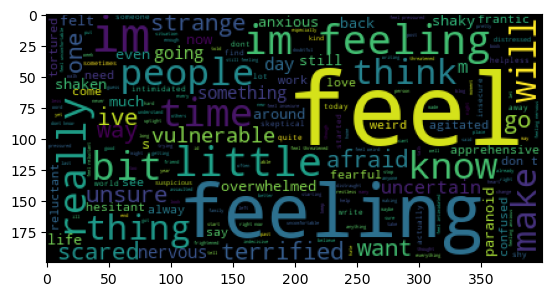

In [32]:
word_cloud = WordCloud().generate(' '.join(fear_data))
plt.imshow(word_cloud)
plt.show()

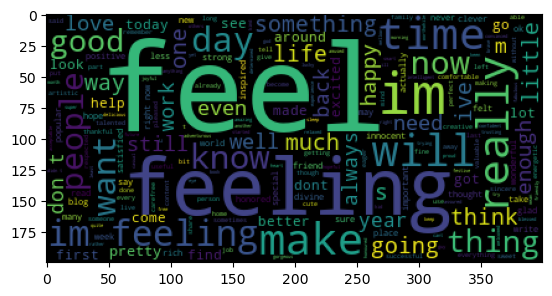

In [33]:
word_cloud = WordCloud().generate(' '.join(joy_data))
plt.imshow(word_cloud)
plt.show()

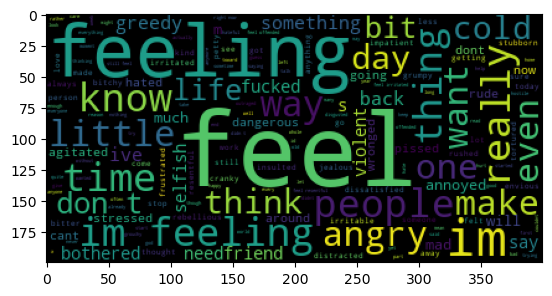

In [34]:
word_cloud = WordCloud().generate(' '.join(anger_data))
plt.imshow(word_cloud)
plt.show()

In [35]:
fear_words = []
for i in words_in_fear_data:
    if (i not in words_in_anger_data) and (i not in words_in_joy_data):
        fear_words.append(i)

joy_words = []
for i in words_in_joy_data:
    if (i not in words_in_anger_data) and (i not in words_in_fear_data):
        joy_words.append(i)

anger_words = []
for i in words_in_anger_data:
    if (i not in words_in_fear_data) and (i not in words_in_joy_data):
        anger_words.append(i)

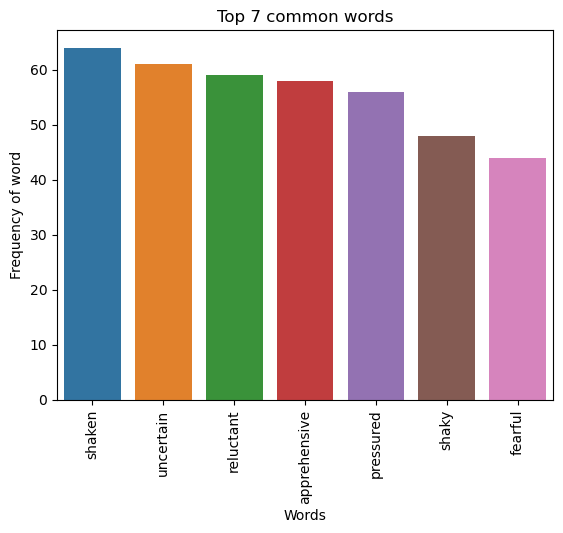

In [36]:
words = []
freq = []
for i,j in Counter(fear_words).most_common(7):
    words.append(i)
    freq.append(j)
sns.barplot(x= words, y= freq)
plt.xlabel('Words')
plt.ylabel('Frequency of word')
plt.title('Top 7 common words')
plt.xticks(rotation = 90)
plt.show()

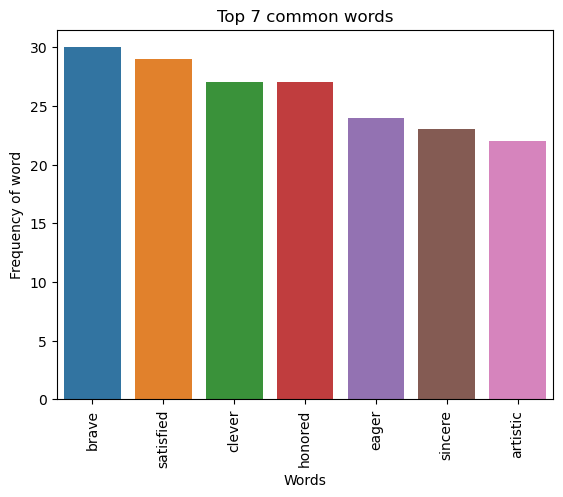

In [37]:
words = []
freq = []
for i,j in Counter(joy_words).most_common(7):
    words.append(i)
    freq.append(j)
sns.barplot(x= words, y= freq)
plt.xlabel('Words')
plt.ylabel('Frequency of word')
plt.title('Top 7 common words')
plt.xticks(rotation = 90)
plt.show()

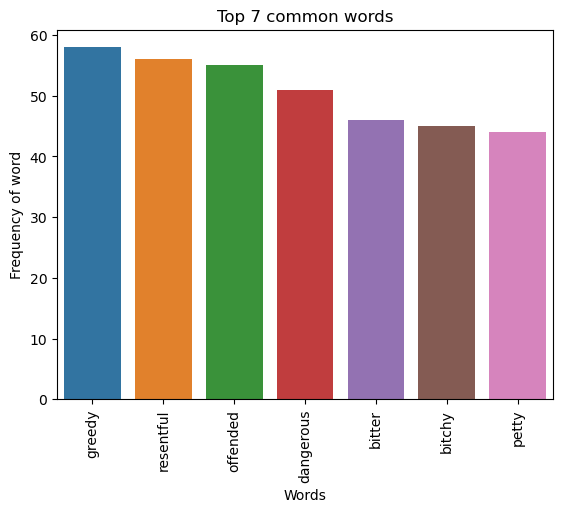

In [38]:
words = []
freq = []
for i,j in Counter(anger_words).most_common(7):
    words.append(i)
    freq.append(j)
sns.barplot(x= words, y= freq)
plt.xlabel('Words')
plt.ylabel('Frequency of word')
plt.title('Top 7 common words')
plt.xticks(rotation = 90)
plt.show()

### 6. Feature Engineering

In [39]:
feature_extraction_pipe = Pipeline([('Pre-Processing',preprocesser_pipe),
                                    ('Vectorization',CountVectorizer(binary= True))])

In [40]:
final_x_train = feature_extraction_pipe.fit_transform(x_train)

final_x_cv = feature_extraction_pipe.transform(x_cv)

final_x_test = feature_extraction_pipe.transform(x_test)

In [41]:
pickle.dump(feature_extraction_pipe,open(r"C:\Users\pavan\Machine Learning\Projects\Project-7(Emotion)\Emotion_feature_extraction.pkl",'wb'))

### 7. Training & Evalution

In [42]:
for i in range(1,10):
    multinomial = MultinomialNB(alpha= i)
    model = multinomial.fit(final_x_train,y_train)
    print(('*'*18 + ' Alpha - {} ' + '*'*18).format(i))
    print(classification_report(y_train, model.predict(final_x_train)))

****************** Alpha - 1 ******************
              precision    recall  f1-score   support

           0       0.97      0.98      0.97      1280
           1       0.97      0.98      0.98      1239
           2       0.99      0.98      0.99      1280

    accuracy                           0.98      3799
   macro avg       0.98      0.98      0.98      3799
weighted avg       0.98      0.98      0.98      3799

****************** Alpha - 2 ******************
              precision    recall  f1-score   support

           0       0.97      0.97      0.97      1280
           1       0.97      0.98      0.97      1239
           2       0.99      0.97      0.98      1280

    accuracy                           0.97      3799
   macro avg       0.97      0.97      0.97      3799
weighted avg       0.97      0.97      0.97      3799

****************** Alpha - 3 ******************
              precision    recall  f1-score   support

           0       0.96      0.97      

In [43]:
for i in range(1,10):
    multinomial = MultinomialNB(alpha= i)
    model = multinomial.fit(final_x_train,y_train)
    print(('*'*18 + ' Alpha - {} ' + '*'*18).format(i))
    print(classification_report(y_cv, model.predict(final_x_cv)))

****************** Alpha - 1 ******************
              precision    recall  f1-score   support

           0       0.88      0.88      0.88       320
           1       0.86      0.92      0.89       310
           2       0.91      0.84      0.87       320

    accuracy                           0.88       950
   macro avg       0.88      0.88      0.88       950
weighted avg       0.88      0.88      0.88       950

****************** Alpha - 2 ******************
              precision    recall  f1-score   support

           0       0.88      0.90      0.89       320
           1       0.87      0.92      0.89       310
           2       0.91      0.84      0.87       320

    accuracy                           0.89       950
   macro avg       0.89      0.89      0.89       950
weighted avg       0.89      0.89      0.89       950

****************** Alpha - 3 ******************
              precision    recall  f1-score   support

           0       0.87      0.90      

### 8. Testing

In [44]:
multinomial = MultinomialNB(alpha= 1)
final_model = multinomial.fit(final_x_train,y_train)

In [45]:
print(classification_report(y_test, model.predict(final_x_test)))

              precision    recall  f1-score   support

           0       0.84      0.94      0.89       400
           1       0.92      0.88      0.90       388
           2       0.91      0.85      0.88       400

    accuracy                           0.89      1188
   macro avg       0.89      0.89      0.89      1188
weighted avg       0.89      0.89      0.89      1188



### 9. Deploying

In [46]:
pickle.dump(final_model,open(r"C:\Users\pavan\Machine Learning\Projects\Project-7(Emotion)\Emotion_model.pkl",'wb'))

### 10. Conclusion

In conclusion, the development of a model for predicting the emotion conveyed in text represents a significant advancement in sentiment analysis. Through the utilization of sophisticated machine learning algorithms and comprehensive datasets, we have the capability to accurately classify text into various emotional categories, ranging from joy and  fear and anger.